In [1]:
%%time
import boto3
import re
import numpy as np
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri

CPU times: user 789 ms, sys: 52 ms, total: 841 ms
Wall time: 844 ms


In [2]:
role = get_execution_role()
print(role)
bucket='zurich-aiml-projects'
training_image = get_image_uri(boto3.Session().region_name, 'image-classification')
print (training_image)

arn:aws:iam::811843694063:role/service-role/AmazonSageMaker-ExecutionRole-20190611T192276
811284229777.dkr.ecr.us-east-1.amazonaws.com/image-classification:1


In [3]:
#the very first step after crreating a bucket is - provide read/write access to Amazon Sagemaker Execution role
#Step 1:Download the .jpeg data from s3 to local directory as we can not use im2rec tool on S3 data directly
!aws s3 cp s3://zurich-aiml-projects/cardamagedetective/dataset/data3a ./dataset/data3a --recursive

download: s3://zurich-aiml-projects/cardamagedetective/dataset/data3a/train_lst/trainingdata03.lst to dataset/data3a/train_lst/trainingdata03.lst
download: s3://zurich-aiml-projects/cardamagedetective/dataset/data3a/training/01-minor/0001.JPEG to dataset/data3a/training/01-minor/0001.JPEG
download: s3://zurich-aiml-projects/cardamagedetective/dataset/data3a/training/01-minor/0005.JPEG to dataset/data3a/training/01-minor/0005.JPEG
download: s3://zurich-aiml-projects/cardamagedetective/dataset/data3a/training/01-minor/0008.JPEG to dataset/data3a/training/01-minor/0008.JPEG
download: s3://zurich-aiml-projects/cardamagedetective/dataset/data3a/training/01-minor/0002.JPEG to dataset/data3a/training/01-minor/0002.JPEG
download: s3://zurich-aiml-projects/cardamagedetective/dataset/data3a/training/01-minor/0010.JPEG to dataset/data3a/training/01-minor/0010.JPEG
download: s3://zurich-aiml-projects/cardamagedetective/dataset/data3a/training/01-minor/0011.JPEG to dataset/data3a/training/01-minor/

In [4]:
#Look at this Image-classification-fulltraining-TestedCode.ipynb notebook for guidance
#Step 2: Download the im2rec.py tool
import os
import urllib.request

def download(url):
    filename = url.split("/")[-1]
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url, filename)
        
# Tool for creating lst file
download('https://raw.githubusercontent.com/apache/incubator-mxnet/master/tools/im2rec.py')

In [5]:
%%bash
#Step 3: Create .lst files for training and validation data
#.lst fils are prepared and stored on sagemaker instance
python im2rec.py --list --recursive ./dataset/data3a/trainingdata03 ./dataset/data3a/training/
python im2rec.py --list --recursive ./dataset/data3a/validationdata03 ./dataset/data3a/validation/
#train-ratio is not specified as the entire data is traning set
#https://arthurcaillau.com/image-record-iter/

01-minor 0
02-moderate 1
03-severe 2
01-minor 0
02-moderate 1
03-severe 2


In [7]:
#Verify the data from .lst files to make sure they are created properly; Number of records should be equal to the number of images in 
#respective training and validation folders
!head -n 100 ./dataset/data3a/validationdata03.lst > example.lst
f = open('example.lst','r')
lst_content = f.read()
print(lst_content)

166	2.000000	03-severe/0064.JPEG
159	2.000000	03-severe/0057.JPEG
81	1.000000	02-moderate/0034.JPEG
57	1.000000	02-moderate/0010.JPEG
0	0.000000	01-minor/0001.JPEG
11	0.000000	01-minor/0012.JPEG
50	1.000000	02-moderate/0003.JPEG
144	2.000000	03-severe/0042.JPEG
120	2.000000	03-severe/0018.JPEG
23	0.000000	01-minor/0024.JPEG
62	1.000000	02-moderate/0015.jpeg
93	1.000000	02-moderate/0046.JPEG
148	2.000000	03-severe/0046.JPEG
154	2.000000	03-severe/0052.JPEG
29	0.000000	01-minor/0030.JPEG
169	2.000000	03-severe/0067.JPEG
165	2.000000	03-severe/0063.JPEG
47	0.000000	01-minor/0048.JPEG
128	2.000000	03-severe/0026.JPEG
113	2.000000	03-severe/0011.JPEG
19	0.000000	01-minor/0020.JPEG
54	1.000000	02-moderate/0007.JPEG
33	0.000000	01-minor/0034.JPEG
158	2.000000	03-severe/0056.JPEG
22	0.000000	01-minor/0023.JPEG
40	0.000000	01-minor/0041.JPEG
68	1.000000	02-moderate/0021.JPEG
151	2.000000	03-severe/0049.JPEG
149	2.000000	03-severe/0047.JPEG
17	0.000000	01-minor/0018.JPEG
107	2.000000	03-severe/0

In [11]:
#Copy the .lst files data to S3 train_lst and validation_lst channels
s3train03 = 's3://{}/cardamagedetective/dataset/data3a/training/'.format(bucket)
s3train03_lst = 's3://{}/cardamagedetective/dataset/data3a/train_lst/'.format(bucket)
s3validation03 = 's3://{}/cardamagedetective/dataset/data3a/validation/'.format(bucket)
s3validation03_lst = 's3://{}/cardamagedetective/dataset/data3a/validation_lst/'.format(bucket)

!aws s3 cp ./dataset/data3a/trainingdata03.lst $s3train03_lst --quiet
!aws s3 cp ./dataset/data3a/validationdata03.lst $s3validation03_lst --quiet
print('Done')

Done


In [12]:
#Training the ResNet model
#Set the hyperparameters (https://docs.aws.amazon.com/sagemaker/latest/dg/IC-Hyperparameter.html)
#This algorithm takes 'images' as input, instead of 'recordIO' file; .lst file is used along with the image files
# The algorithm supports multiple network depth (number of layers). They are 18, 34, 50, 101, 152 and 200
# For this training, we will use 18 layers
num_layers = "18" 
# we need to specify the input image shape for the training data
image_shape = "3,256,256"  
#for image_shape, when I give 2, the training job failed with error: Transfer learning only supports color images (3-channel) as input.
#The format is defined as 'num_channels, height, width'. The image dimension can take on any value as the network can handle varied dimensions of the input. 
#However, there may be memory constraints if a larger image dimension is used. 
#Typical image dimensions for image classification are '3, 224, 224'. This is similar to the ImageNet dataset.
# we also need to specify the number of training samples in the training set
# we have  419+288+272 = 979
num_training_samples = "979"
# specify the number of output classes
num_classes = 3 #is car damage location 'minor', or 'moderate' or 'severe'
# batch size for training
mini_batch_size =  "128"
# number of epochs
epochs = "10"
# learning rate
learning_rate = "0.01"
#report top 5 accuracy
top_k = "5"
#resize image before training
resize = "256"
#period to store modle parameters (in number of epochs), in this case, we will save parameters from epoch 2,4,and 6
checkpoint_frequency = 2
#since we are using transfer leanring, we set use_pretrained_model to 1, so that weights can be initialized with pretrained weights
use_pretrained_model = 1

In [13]:
%%time
#Model training: Run the training using Amazon sagemaker CreateTrainingJob API
import time
import boto3
from time import gmtime, strftime


s3 = boto3.client('s3')
# create unique job name 
job_name_prefix = 'cardamagedetective-damage-severity'
timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
job_name = job_name_prefix + timestamp
training_params = \
{
    # specify the training docker image
    "AlgorithmSpecification": {
        "TrainingImage": training_image,
        "TrainingInputMode": "File"
    },
    "RoleArn": role,
    "OutputDataConfig": {
        "S3OutputPath": 's3://{}/cardamagedetective/modeloutput'.format(bucket)
    },
    "ResourceConfig": {
        "InstanceCount": 1,
        "InstanceType": "ml.p2.xlarge",
        "VolumeSizeInGB": 50
    },
    "TrainingJobName": job_name,
    "HyperParameters": {
        "image_shape": image_shape,
        "num_layers": str(num_layers),
        "num_training_samples": str(num_training_samples),
        "num_classes": str(num_classes),
        "mini_batch_size": str(mini_batch_size),
        "epochs": str(epochs),
        "learning_rate": str(learning_rate),
        "top_k": str(top_k),
        "resize": str(resize),
        "checkpoint_frequency": str(checkpoint_frequency),
        "use_pretrained_model": str(use_pretrained_model)
    },
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 360000
    },
#Need to provide S3 path for 4 channels - training, validation, train_lst and valdiation_lst
#Set the location by setting S3Uri variable. 
#Training data should be inside a subdirectory called "train"
#Validation data should be inside a subdirectory called "validation"
#The algorithm currently only supports fullyreplicated model (where data is copied onto each machine)
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": s3train03,
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "application/x-image", #use x-image as we are using actual image data, instead of recordIO format
            "RecordWrapperType": "None",
            "CompressionType": "None"
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": s3validation03,
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "application/x-image",   #use x-image as we are using actual image data, instead of recordIO format
            "RecordWrapperType": "None",
            "CompressionType": "None"
        },
        {
            "ChannelName": "train_lst",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": s3train03_lst,
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "application/x-image",   #use x-image as we are using actual image data, instead of recordIO format
            "RecordWrapperType": "None",
            "CompressionType": "None"
        },
        {
            "ChannelName": "validation_lst",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": s3validation03_lst,
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "application/x-image",   #use x-image as we are using actual image data, instead of recordIO format
            "RecordWrapperType": "None",
            "CompressionType": "None"
        }
    ]
}
print('Training job name: {}'.format(job_name))
print('\nInput Data Location: {}'.format(training_params['InputDataConfig'][0]['DataSource']['S3DataSource']))

Training job name: cardamagedetective-damage-severity-2019-06-21-10-59-27

Input Data Location: {'S3DataType': 'S3Prefix', 'S3Uri': 's3://zurich-aiml-projects/cardamagedetective/dataset/data3a/training/', 'S3DataDistributionType': 'FullyReplicated'}
CPU times: user 40.5 ms, sys: 12.6 ms, total: 53.1 ms
Wall time: 63.2 ms


In [14]:
# create the Amazon SageMaker training job
sagemaker = boto3.client(service_name='sagemaker')
sagemaker.create_training_job(**training_params)

# confirm that the training job has started
status = sagemaker.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
print('Training job current status: {}'.format(status))

try:
    # waits for the job to finish and report the ending status (success/fail)
    sagemaker.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=job_name)
    training_info = sagemaker.describe_training_job(TrainingJobName=job_name)
    status = training_info['TrainingJobStatus']
    print("Training job ended with status: " + status)
except:
    print('Training failed to start')
     # if exception is raised, that means it has failed
    message = sagemaker.describe_training_job(TrainingJobName=job_name)['FailureReason']
    print('Training failed with the following error: {}'.format(message))
# At the end of training job, you will find the model file created in S3 under output folder:s3://../modeloutput/cardamagedetective-car-or-not-2019-06-21-04-32-18/output/model.tar.gz

Training job current status: InProgress
Training job ended with status: Completed


In [15]:
training_info = sagemaker.describe_training_job(TrainingJobName=job_name)
status = training_info['TrainingJobStatus']
print("Training job ended with status: " + status)
print(training_info)

Training job ended with status: Completed
{'TrainingJobName': 'cardamagedetective-damage-severity-2019-06-21-10-59-27', 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:811843694063:training-job/cardamagedetective-damage-severity-2019-06-21-10-59-27', 'ModelArtifacts': {'S3ModelArtifacts': 's3://zurich-aiml-projects/cardamagedetective/modeloutput/cardamagedetective-damage-severity-2019-06-21-10-59-27/output/model.tar.gz'}, 'TrainingJobStatus': 'Completed', 'SecondaryStatus': 'Completed', 'HyperParameters': {'checkpoint_frequency': '2', 'epochs': '10', 'image_shape': '3,256,256', 'learning_rate': '0.01', 'mini_batch_size': '128', 'num_classes': '3', 'num_layers': '18', 'num_training_samples': '979', 'resize': '256', 'top_k': '5', 'use_pretrained_model': '1'}, 'AlgorithmSpecification': {'TrainingImage': '811284229777.dkr.ecr.us-east-1.amazonaws.com/image-classification:1', 'TrainingInputMode': 'File', 'MetricDefinitions': [{'Name': 'train:accuracy', 'Regex': 'Epoch\\S* Train-accuracy=(\\S*

In [16]:
%%time
#Create Model
import boto3
from time import gmtime, strftime

sage = boto3.Session().client(service_name='sagemaker') 
timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())

model_name="cardamagedetective-damage-location" + timestamp
print(model_name)

info = sage.describe_training_job(TrainingJobName=job_name)
model_data = info['ModelArtifacts']['S3ModelArtifacts']
print(model_data)

hosting_image = get_image_uri(boto3.Session().region_name, 'image-classification')
primary_container = {
    'Image': hosting_image,
    'ModelDataUrl': model_data,
}

create_model_response = sage.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

print(create_model_response['ModelArn'])

cardamagedetective-damage-location-2019-06-21-11-08-16
s3://zurich-aiml-projects/cardamagedetective/modeloutput/cardamagedetective-damage-severity-2019-06-21-10-59-27/output/model.tar.gz
arn:aws:sagemaker:us-east-1:811843694063:model/cardamagedetective-damage-location-2019-06-21-11-08-16
CPU times: user 66.8 ms, sys: 3.94 ms, total: 70.7 ms
Wall time: 408 ms


In [17]:
#Create Endpoint Configuration for the model craeted/stored in S3
from time import gmtime, strftime

timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
endpoint_config_name = job_name_prefix + '-epc-' + timestamp
endpoint_config_response = sage.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType':'ml.m4.xlarge',
        'InitialInstanceCount':1,
        'ModelName':model_name,
        'VariantName':'AllTraffic'}])

print('Endpoint configuration name: {}'.format(endpoint_config_name))
print('Endpoint configuration arn:  {}'.format(endpoint_config_response['EndpointConfigArn']))

Endpoint configuration name: cardamagedetective-damage-severity-epc--2019-06-21-11-08-23
Endpoint configuration arn:  arn:aws:sagemaker:us-east-1:811843694063:endpoint-config/cardamagedetective-damage-severity-epc--2019-06-21-11-08-23


In [18]:
%%time
#Create Endpoint by leveraging abovementioned Endpoint Configuration so that this cam be consumed by the end client applications
import time

timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
endpoint_name = job_name_prefix + '-ep-' + timestamp
print('Endpoint name: {}'.format(endpoint_name))

endpoint_params = {
    'EndpointName': endpoint_name,
    'EndpointConfigName': endpoint_config_name,
}
endpoint_response = sagemaker.create_endpoint(**endpoint_params)
print('EndpointArn = {}'.format(endpoint_response['EndpointArn']))

Endpoint name: cardamagedetective-damage-severity-ep--2019-06-21-11-08-41
EndpointArn = arn:aws:sagemaker:us-east-1:811843694063:endpoint/cardamagedetective-damage-severity-ep--2019-06-21-11-08-41
CPU times: user 14.2 ms, sys: 175 µs, total: 14.3 ms
Wall time: 239 ms


In [19]:
# Get the status of the endpoint
response = sagemaker.describe_endpoint(EndpointName=endpoint_name)
status = response['EndpointStatus']
print('EndpointStatus = {}'.format(status))


# wait until the status has changed
sagemaker.get_waiter('endpoint_in_service').wait(EndpointName=endpoint_name)


# print the status of the endpoint
endpoint_response = sagemaker.describe_endpoint(EndpointName=endpoint_name)
status = endpoint_response['EndpointStatus']
print('Endpoint creation ended with EndpointStatus = {}'.format(status))

if status != 'InService':
    raise Exception('Endpoint creation failed.')

EndpointStatus = Creating
Endpoint creation ended with EndpointStatus = InService


In [20]:
#Perform Inference
import boto3
runtime = boto3.Session().client(service_name='runtime.sagemaker') 

--2019-06-21 11:20:08--  https://upload.wikimedia.org/wikipedia/commons/4/46/Car_Accident.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1732369 (1.7M) [image/jpeg]
Saving to: ‘/tmp/test.jpg’

/tmp/test.jpg       100%[===================>]   1.65M  --.-KB/s    in 0.05s   

2019-06-21 11:20:08 (30.3 MB/s) - ‘/tmp/test.jpg’ saved [1732369/1732369]



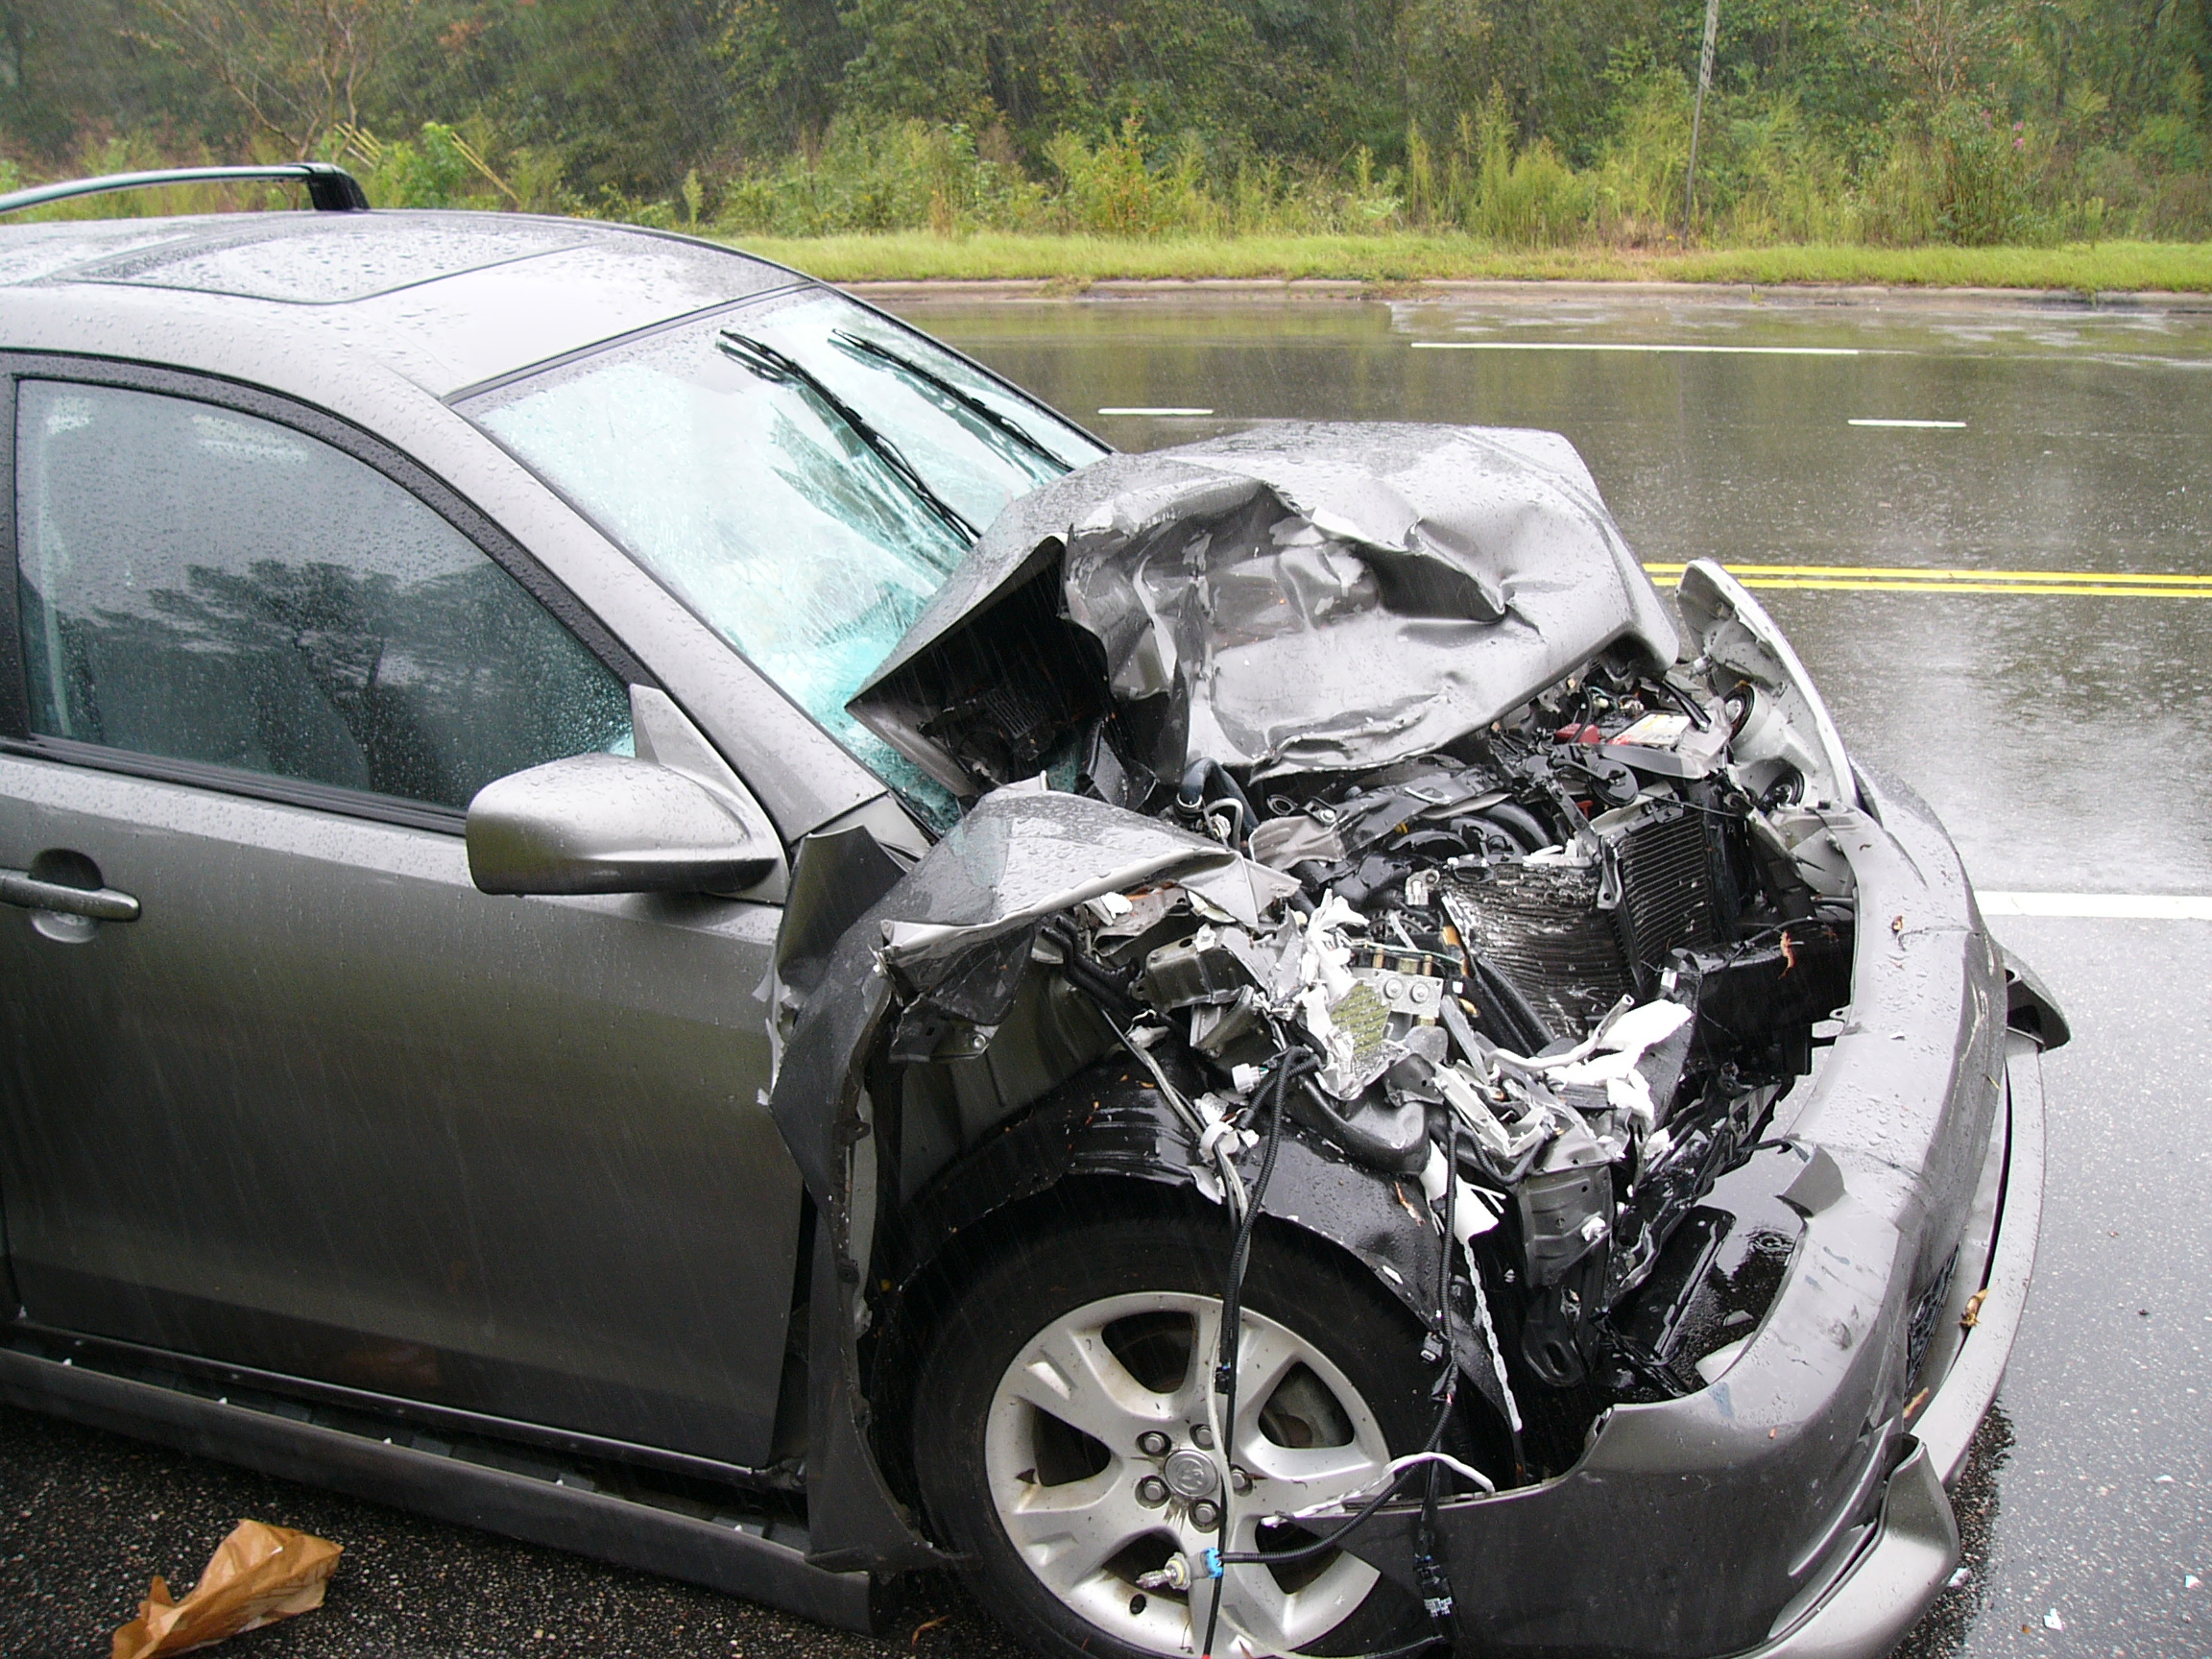

In [31]:
#Model testing with single image
#Download image
#Make corresponding S3 dataset folder public
#!wget -O /tmp/test.jpg https://s3.amazonaws.com/zurich-aiml-projects/cardamagedetective/dataset/data3a/training/01-minor/0001.JPEG
#!wget -O /tmp/test.jpg https://s3.amazonaws.com/zurich-aiml-projects/cardamagedetective/dataset/data3a/training/02-moderate/0002.JPEG
#!wget -O /tmp/test.jpg https://s3.amazonaws.com/zurich-aiml-projects/cardamagedetective/dataset/data3a/training/03-severe/0001.JPEG
!wget -O /tmp/test.jpg https://upload.wikimedia.org/wikipedia/commons/4/46/Car_Accident.jpg
#!wget -O /tmp/test.jpg https://upload.wikimedia.org/wikipedia/commons/thumb/2/25/2015_Mazda_MX-5_ND_2.0_SKYACTIV-G_160_i-ELOOP_Rubinrot-Metallic_Vorderansicht.jpg/1920px-2015_Mazda_MX-5_ND_2.0_SKYACTIV-G_160_i-ELOOP_Rubinrot-Metallic_Vorderansicht.jpg
file_name = '/tmp/test.jpg'
# test image
from IPython.display import Image
Image(file_name) 

In [32]:
import json
import numpy as np

with open(file_name, 'rb') as f:
    payload = f.read()
    payload = bytearray(payload)
response = runtime.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType='application/x-image', 
                                   Body=payload)
result = response['Body'].read()
# result will be in json format and convert it to ndarray
result = json.loads(result)
# the result will output the probabilities for all classes
# find the class with maximum probability and print the class index
index = np.argmax(result)
object_categories = ['Minor damage', 'Moderate damage', 'Severe damage']
print("Result: label - " + object_categories[index] + ", probability - " + str(result[index]))
#for an image with no damage, it shows one of these 3 categories with low probability; in case of damaged image, it shows correly with high probability

Result: label - Severe damage, probability - 0.9954130053520203


In [33]:
#Delete endpoint to avoid incurring compute instance charges
sage.delete_endpoint(EndpointName=endpoint_name)

{'ResponseMetadata': {'RequestId': '90a0bf55-16af-47ca-bd5e-b3a880fdc376',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '90a0bf55-16af-47ca-bd5e-b3a880fdc376',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Fri, 21 Jun 2019 11:20:18 GMT'},
  'RetryAttempts': 0}}